In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE


In [42]:
import gc

def optimize_memory(df):
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')
    return df

train_dataset = "GUIDE_Train.csv"
chunks = []

try:
    for chunk in pd.read_csv(train_dataset, chunksize=100000, low_memory=False, encoding='utf-8'):
        try:
            chunk = optimize_memory(chunk)
            chunks.append(chunk)
        except pd.errors.ParserError:
            pass  # Skip this chunk if there's a parsing error
except FileNotFoundError:
    print("File not found. Please check the file path.")
except pd.errors.EmptyDataError:
    print("File is empty.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Concatenate all chunks if there's any valid data
if chunks:
    train_data = pd.concat(chunks, ignore_index=True)
    # Clean up memory
    del chunks
    gc.collect()
    print("Data concatenated successfully.")
else:
    print("No valid data to concatenate.")

Data concatenated successfully.


In [30]:
import gc

def optimize_memory(df):
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')
    return df

test_dataset = "GUIDE_Test.csv"
chunks = []

try:
    for chunk in pd.read_csv(test_dataset, chunksize=100000, low_memory=False, encoding='utf-8'):
        try:
            chunk = optimize_memory(chunk)
            chunks.append(chunk)
        except pd.errors.ParserError:
            pass  # Skip this chunk if there's a parsing error
except FileNotFoundError:
    print("File not found. Please check the file path.")
except pd.errors.EmptyDataError:
    print("File is empty.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Concatenate all chunks if there's any valid data
if chunks:
    test_data = pd.concat(chunks, ignore_index=True)
    # Clean up memory
    del chunks
    gc.collect()
    print("Data concatenated successfully.")
else:
    print("No valid data to concatenate.")

Data concatenated successfully.


In [43]:
train_data.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [44]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype   
---  ------              -----   
 0   Id                  int64   
 1   OrgId               int16   
 2   IncidentId          int32   
 3   AlertId             int32   
 4   Timestamp           object  
 5   DetectorId          int16   
 6   AlertTitle          int32   
 7   Category            object  
 8   MitreTechniques     object  
 9   IncidentGrade       category
 10  ActionGrouped       object  
 11  ActionGranular      object  
 12  EntityType          object  
 13  EvidenceRole        category
 14  DeviceId            int32   
 15  Sha256              int32   
 16  IpAddress           int32   
 17  Url                 int32   
 18  AccountSid          int32   
 19  AccountUpn          int32   
 20  AccountObjectId     int32   
 21  AccountName         int32   
 22  DeviceName          int32   
 23  NetworkMessageId    int32   
 24

In [45]:
#HANDLING MISSING DATA
train_data.isnull().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       5468386
IncidentGrade           51340
ActionGrouped         9460773
ActionGranular        9460773
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        9420025
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          9441956
FileName                    0
FolderPath

In [46]:
train_data.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade',
       'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'EmailClusterId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath',
       'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
       'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode',
       'State', 'City'],
      dtype='object')

In [48]:
# Droping Columns with More Than 50% Missing Values:
threshold = len(train_data) * 0.5
train_data = train_data.loc[:, train_data.isnull().sum() <= threshold]

In [49]:
train_data

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,...,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,TruePositive,Ip,...,3421,881,289573,117668,3586,5,66,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,FalsePositive,User,...,3421,881,289573,117668,3586,5,66,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,FalsePositive,Url,...,3421,881,289573,117668,3586,5,66,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,BenignPositive,Url,...,3421,881,289573,117668,3586,5,66,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,TruePositive,User,...,3421,881,289573,117668,3586,5,66,242,1445,10630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9516832,1056561956622,0,90,496631,2024-06-08T15:26:08.000Z,7,6,InitialAccess,TruePositive,CloudLogonRequest,...,3421,881,289573,117668,3586,5,66,242,1445,10630
9516833,1228360650033,59,196410,748366,2024-06-06T09:40:08.000Z,2,2,CommandAndControl,BenignPositive,Url,...,3421,881,289573,117668,3586,5,66,242,1445,10630
9516834,867583395122,44,14117,7425,2024-06-11T22:51:03.000Z,78,57,Exfiltration,BenignPositive,MailMessage,...,3421,881,289573,117668,3586,5,66,242,1445,10630
9516835,395136991850,43,644,8973,2024-05-20T23:01:01.000Z,52,10,Impact,BenignPositive,Ip,...,3421,881,289573,117668,3586,5,66,242,1445,10630


In [12]:
train_data.isnull().sum()

Id                        0
OrgId                     0
IncidentId                0
AlertId                   0
Timestamp                 0
DetectorId                0
AlertTitle                0
Category                  0
IncidentGrade         51340
EntityType                0
EvidenceRole              0
DeviceId                  0
Sha256                    0
IpAddress                 0
Url                       0
AccountSid                0
AccountUpn                0
AccountObjectId           0
AccountName               0
DeviceName                0
NetworkMessageId          0
RegistryKey               0
RegistryValueName         0
RegistryValueData         0
ApplicationId             0
ApplicationName           0
OAuthApplicationId        0
FileName                  0
FolderPath                0
ResourceIdName            0
OSFamily                  0
OSVersion                 0
CountryCode               0
State                     0
City                      0
dtype: int64

In [50]:
train_data['IncidentGrade'].value_counts()

IncidentGrade
BenignPositive    4110817
TruePositive      3322713
FalsePositive     2031967
Name: count, dtype: int64

In [51]:
# Fill NaN values in 'IncidentGrade' with the mode
mode_value = train_data['IncidentGrade'].mode()[0]  # Get the mode of the column
train_data['IncidentGrade'].fillna(mode_value, inplace=True)

In [52]:

train_data.isnull().sum()

Id                    0
OrgId                 0
IncidentId            0
AlertId               0
Timestamp             0
DetectorId            0
AlertTitle            0
Category              0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
dtype: int64

In [53]:
train_data.duplicated().sum()

np.int64(546298)

In [54]:
# Droping duplicate rows from the dataset
train_data = train_data.drop_duplicates()

In [55]:

# Target variable distribution
print("Target variable distribution:")
train_data['IncidentGrade'].value_counts()

Target variable distribution:


IncidentGrade
BenignPositive    3875534
TruePositive      3140126
FalsePositive     1954879
Name: count, dtype: int64

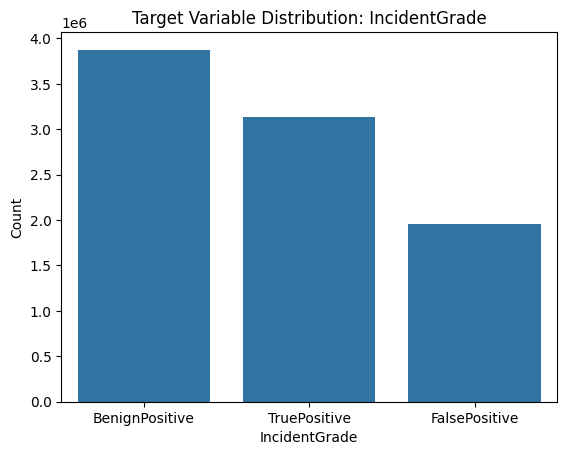

In [56]:
sns.countplot(data=train_data, x='IncidentGrade', order=train_data['IncidentGrade'].value_counts().index)
plt.title('Target Variable Distribution: IncidentGrade')
plt.xlabel('IncidentGrade')
plt.ylabel('Count')
plt.show()

FEATURE ENGINEERING AND EDA

In [58]:
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'])
train_data['Year'] = train_data['Timestamp'].dt.year
train_data['Month'] = train_data['Timestamp'].dt.month
train_data['Day'] = train_data['Timestamp'].dt.day
train_data['Hour'] = train_data['Timestamp'].dt.hour

In [59]:
train_data.drop(columns='Timestamp',inplace=True)

In [60]:

train_data.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

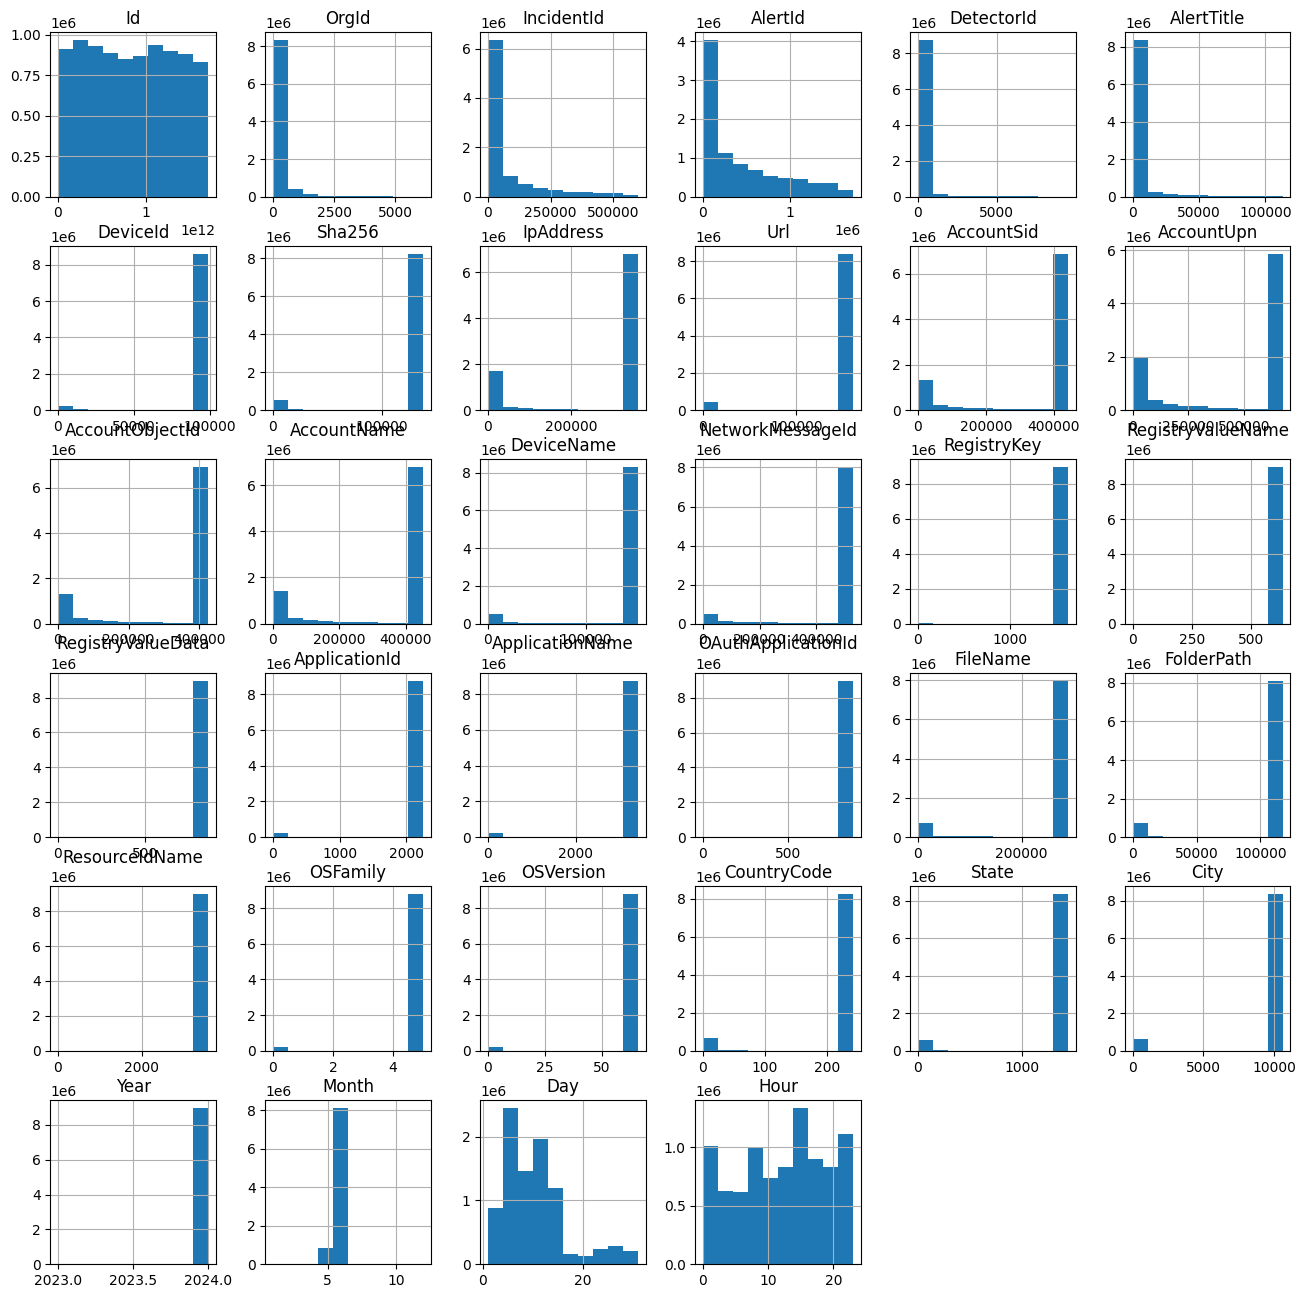

In [62]:
train_data.hist(figsize=(16,16))
plt.show()

In [63]:
# Bar plot for categorical data
# List of categorical columns in DataFrame
categorical_columns = train_data.select_dtypes(include=['object','category'])

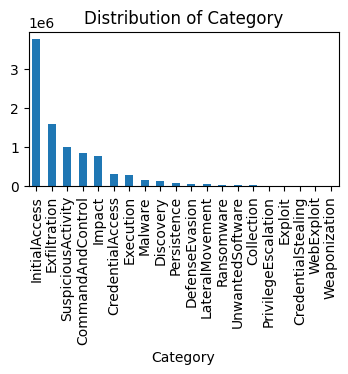

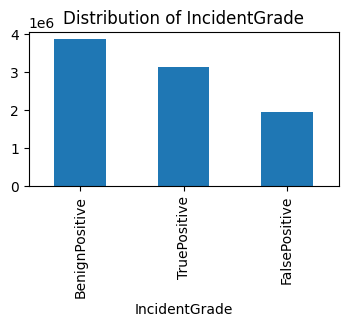

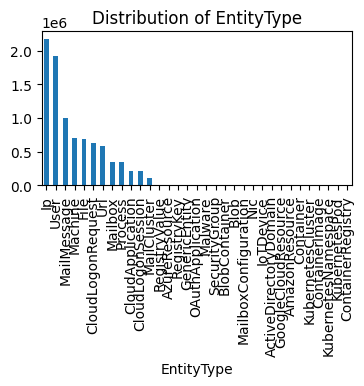

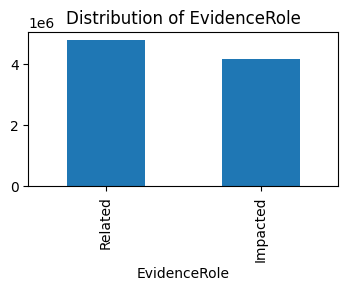

In [64]:
for col in categorical_columns:
    plt.figure(figsize=(4, 2))
    train_data[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.show()

In [65]:
train_data.dtypes

Id                       int64
OrgId                    int16
IncidentId               int32
AlertId                  int32
DetectorId               int16
AlertTitle               int32
Category                object
IncidentGrade         category
EntityType              object
EvidenceRole          category
DeviceId                 int32
Sha256                   int32
IpAddress                int32
Url                      int32
AccountSid               int32
AccountUpn               int32
AccountObjectId          int32
AccountName              int32
DeviceName               int32
NetworkMessageId         int32
RegistryKey              int16
RegistryValueName        int16
RegistryValueData        int16
ApplicationId            int16
ApplicationName          int16
OAuthApplicationId       int16
FileName                 int32
FolderPath               int32
ResourceIdName           int16
OSFamily                  int8
OSVersion                 int8
CountryCode              int16
State   

In [66]:
# List of Numerical columns in DataFrame
numeric_columns = train_data.select_dtypes(include=['int8','int16', 'int32', 'int64', 'float64'])
# cheking num columns
numeric_columns.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

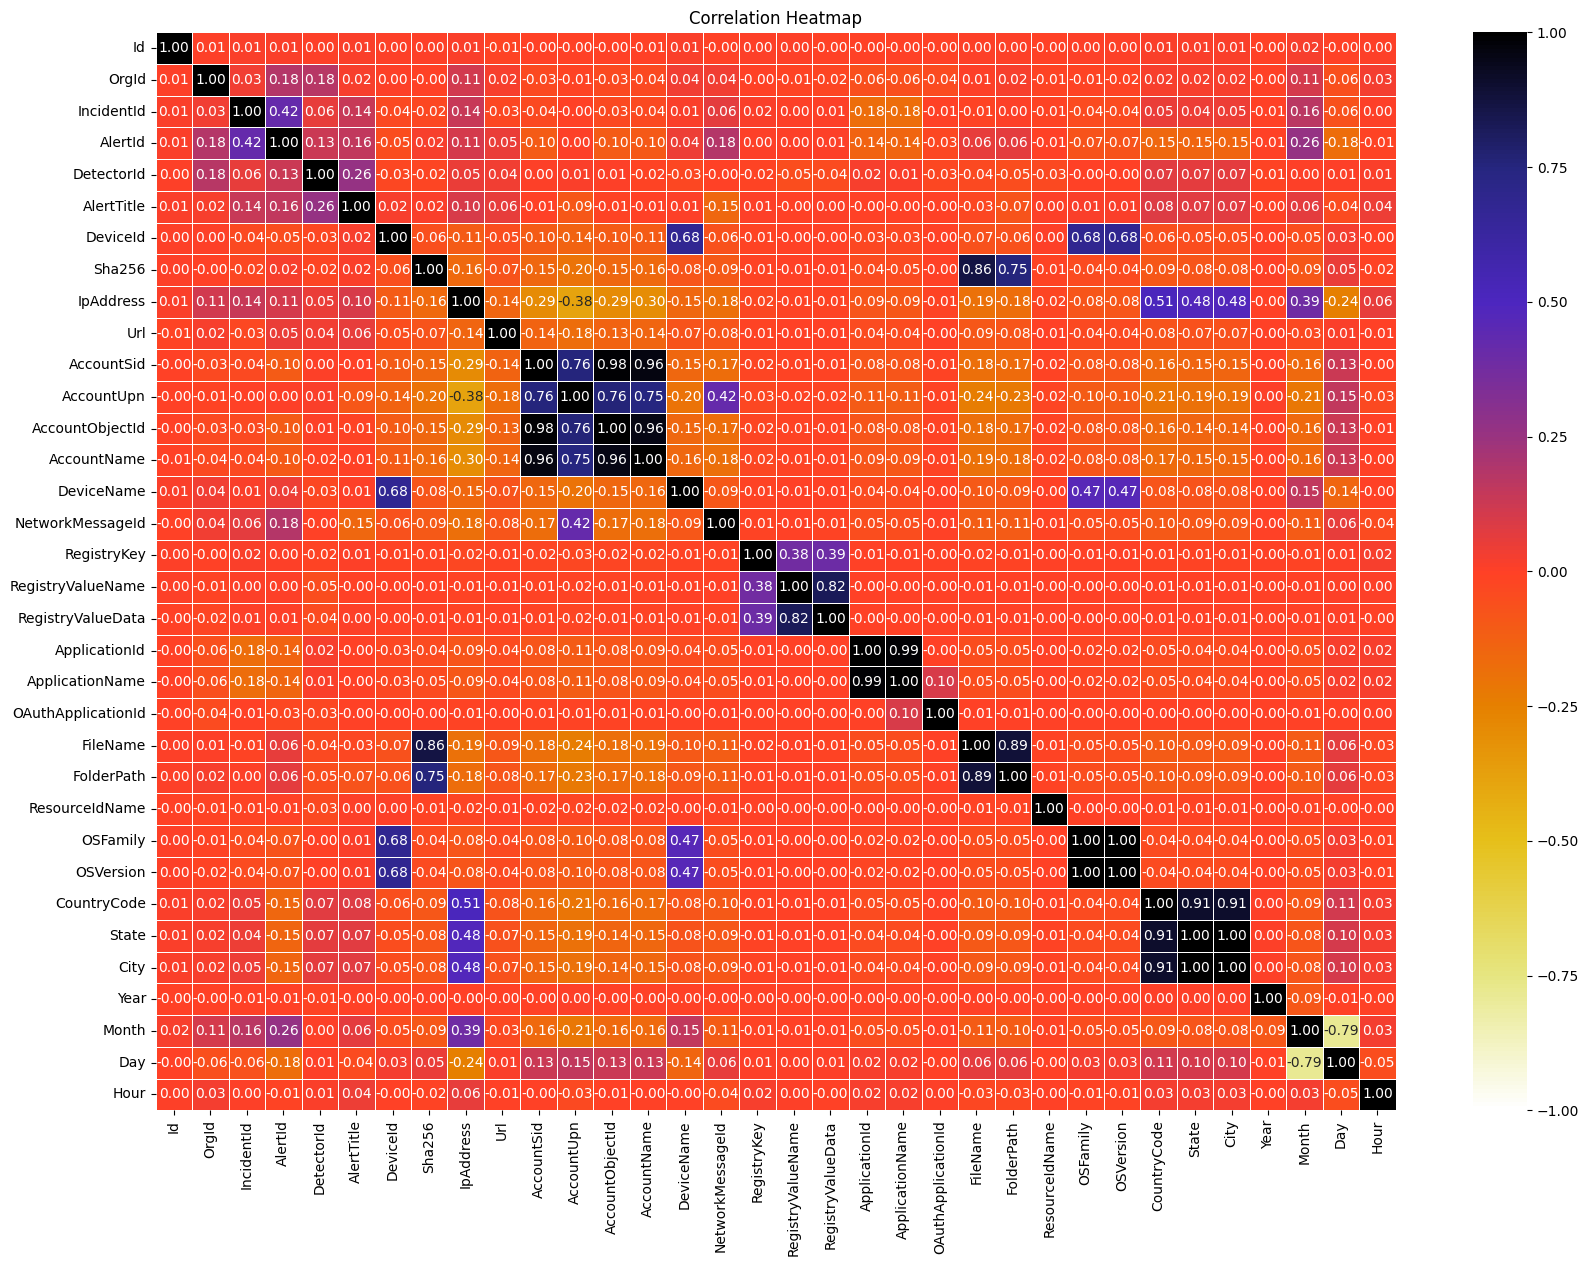

In [67]:
# heatmap visualization
plt.figure(figsize=(20, 14))
sns.heatmap(numeric_columns.corr(), annot=True, fmt='.2f', cmap='CMRmap_r', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [68]:
def correlation(dataset,threshold):
    col_cor=set()
    corr_matrix=dataset.corr()
    for i in range (len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>threshold:
                colname=corr_matrix.columns[i]
                col_cor.add(colname)
    return col_cor

In [69]:
corr_features=correlation(numeric_columns,0.7)
corr_features

{'AccountName',
 'AccountObjectId',
 'AccountUpn',
 'ApplicationName',
 'City',
 'Day',
 'FileName',
 'FolderPath',
 'OSVersion',
 'RegistryValueData',
 'State'}

In [70]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier

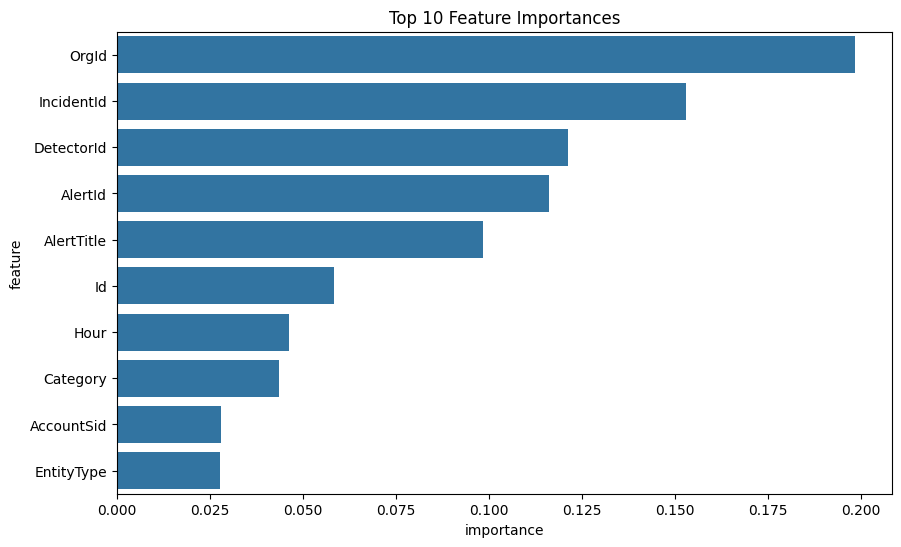

In [71]:
train_sample = train_data.sample(frac=0.001, random_state=42)

X = train_sample.drop(corr_features.union(['IncidentGrade']), axis=1, errors='ignore')
y = train_sample['IncidentGrade']

# Label encoding for non-numeric columns
non_numeric_cols = X.select_dtypes(exclude=['number']).columns
le = LabelEncoder()
for col in non_numeric_cols:
    X[col] = le.fit_transform(X[col].astype(str))

# Train a Random Forest model
rf = RandomForestClassifier()
rf.fit(X, y)

# Compute feature importances
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Visualize the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

In [72]:
feature_importances

,feature,importance
1,OrgId,0.198290
2,IncidentId,0.152861
4,DetectorId,0.121197
3,AlertId,0.116099
5,AlertTitle,0.098508
0,Id,0.058273
25,Hour,0.046324
6,Category,0.043628
13,AccountSid,0.027904
7,EntityType,0.027839


In [73]:
# Set the threshold for feature importance
importance_threshold = 0.01

# Identify the unimportant columns
unimportant_features = feature_importances[feature_importances['importance'] < importance_threshold]['feature']
print(f"Columns to drop due to low importance: {list(unimportant_features)}")

Columns to drop due to low importance: ['Url', 'EvidenceRole', 'Month', 'DeviceId', 'ApplicationId', 'OSFamily', 'RegistryKey', 'ResourceIdName', 'RegistryValueName', 'OAuthApplicationId', 'Year']


In [74]:
# Drop unimportant columns from the training data
X_filtered = train_data.drop(columns=unimportant_features, axis=1)
X_filtered

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,Sha256,...,RegistryValueData,ApplicationName,FileName,FolderPath,OSVersion,CountryCode,State,City,Day,Hour
0,180388628218,0,612,123247,7,6,InitialAccess,TruePositive,Ip,138268,...,860,3421,289573,117668,66,31,6,3,4,6
1,455266534868,88,326,210035,58,43,Exfiltration,FalsePositive,User,138268,...,860,3421,289573,117668,66,242,1445,10630,14,3
2,1056561957389,809,58352,712507,423,298,InitialAccess,FalsePositive,Url,138268,...,860,3421,289573,117668,66,242,1445,10630,13,4
3,1279900258736,92,32992,774301,2,2,CommandAndControl,BenignPositive,Url,138268,...,860,3421,289573,117668,66,242,1445,10630,10,16
4,214748368522,148,4359,188041,9,74,Execution,TruePositive,User,138268,...,860,3421,289573,117668,66,242,1445,10630,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9516832,1056561956622,0,90,496631,7,6,InitialAccess,TruePositive,CloudLogonRequest,138268,...,860,3421,289573,117668,66,242,1445,10630,8,15
9516833,1228360650033,59,196410,748366,2,2,CommandAndControl,BenignPositive,Url,138268,...,860,3421,289573,117668,66,242,1445,10630,6,9
9516834,867583395122,44,14117,7425,78,57,Exfiltration,BenignPositive,MailMessage,138268,...,860,3421,289573,117668,66,242,1445,10630,11,22
9516835,395136991850,43,644,8973,52,10,Impact,BenignPositive,Ip,138268,...,860,3421,289573,117668,66,242,1445,10630,20,23


In [75]:
X_filtered.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'Sha256', 'IpAddress',
       'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName',
       'DeviceName', 'NetworkMessageId', 'RegistryValueData',
       'ApplicationName', 'FileName', 'FolderPath', 'OSVersion', 'CountryCode',
       'State', 'City', 'Day', 'Hour'],
      dtype='object')

In [76]:
columns_to_drop = [
    'AccountUpn', 'AccountObjectId', 'RegistryValueData', 'ApplicationName',
    'FileName', 'FolderPath'
]
df_Train = X_filtered.drop(columns=columns_to_drop, axis=1)
df_Train

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,Sha256,...,AccountSid,AccountName,DeviceName,NetworkMessageId,OSVersion,CountryCode,State,City,Day,Hour
0,180388628218,0,612,123247,7,6,InitialAccess,TruePositive,Ip,138268,...,441377,453297,153085,529644,66,31,6,3,4,6
1,455266534868,88,326,210035,58,43,Exfiltration,FalsePositive,User,138268,...,22406,24887,153085,529644,66,242,1445,10630,14,3
2,1056561957389,809,58352,712507,423,298,InitialAccess,FalsePositive,Url,138268,...,441377,453297,153085,529644,66,242,1445,10630,13,4
3,1279900258736,92,32992,774301,2,2,CommandAndControl,BenignPositive,Url,138268,...,441377,453297,153085,529644,66,242,1445,10630,10,16
4,214748368522,148,4359,188041,9,74,Execution,TruePositive,User,138268,...,449,479,153085,529644,66,242,1445,10630,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9516832,1056561956622,0,90,496631,7,6,InitialAccess,TruePositive,CloudLogonRequest,138268,...,441377,453297,153085,529644,66,242,1445,10630,8,15
9516833,1228360650033,59,196410,748366,2,2,CommandAndControl,BenignPositive,Url,138268,...,441377,453297,153085,529644,66,242,1445,10630,6,9
9516834,867583395122,44,14117,7425,78,57,Exfiltration,BenignPositive,MailMessage,138268,...,441377,453297,153085,22919,66,242,1445,10630,11,22
9516835,395136991850,43,644,8973,52,10,Impact,BenignPositive,Ip,138268,...,441377,453297,153085,529644,66,242,1445,10630,20,23


In [77]:
# Handling Outliers
def outliers(df, iqr_multiplier=1.5):
    numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64'])
    for col in numeric_features.columns:
        Q1 = numeric_features[col].quantile(0.25)
        Q3 = numeric_features[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
            
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [78]:
df=outliers(df_Train,iqr_multiplier=1.5)

In [79]:
df

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,Sha256,...,AccountSid,AccountName,DeviceName,NetworkMessageId,OSVersion,CountryCode,State,City,Day,Hour
3,1279900258736,92,32992,774301,2,2,CommandAndControl,BenignPositive,Url,138268,...,441377,453297,153085,529644,66,242,1445,10630,10,16
24,824633723860,75,478,939479,4,3,InitialAccess,TruePositive,CloudLogonRequest,138268,...,441377,453297,153085,529644,66,242,1445,10630,3,14
27,489626273557,0,211,160158,0,0,InitialAccess,TruePositive,CloudLogonRequest,138268,...,441377,453297,153085,529644,66,242,1445,10630,11,8
42,231928235439,88,26726,1114326,58,43,Exfiltration,FalsePositive,MailMessage,138268,...,441377,453297,153085,529644,66,242,1445,10630,10,1
44,1374389538210,2,11288,3523,15,13,Exfiltration,BenignPositive,File,138268,...,441377,453297,153085,529644,66,242,1445,10630,11,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9516822,103079216152,47,3069,6791,57,29,CommandAndControl,FalsePositive,Url,138268,...,441377,453297,153085,529644,66,242,1445,10630,3,2
9516826,1692217116375,0,440,164344,0,0,InitialAccess,TruePositive,CloudLogonRequest,138268,...,441377,453297,153085,529644,66,242,1445,10630,6,20
9516828,1108101564153,0,319,499915,0,0,InitialAccess,TruePositive,CloudLogonRequest,138268,...,441377,453297,153085,529644,66,242,1445,10630,7,22
9516832,1056561956622,0,90,496631,7,6,InitialAccess,TruePositive,CloudLogonRequest,138268,...,441377,453297,153085,529644,66,242,1445,10630,8,15


In [80]:
df.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'Sha256', 'IpAddress',
       'AccountSid', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'OSVersion', 'CountryCode', 'State', 'City', 'Day', 'Hour'],
      dtype='object')

In [81]:
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId','Sha256', 
              'IpAddress', 'AccountSid', 'AccountName', 
              'DeviceName', 'NetworkMessageId']

In [82]:
# Exclude ID columns from scaling
numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).drop(columns=id_columns, errors='ignore')

In [83]:
#Scaling numerical features
scaler = MinMaxScaler()
df[numeric_features.columns] = scaler.fit_transform(numeric_features)


In [84]:
# categorical columns
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType']

In [85]:
for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))  # Convert to string if necessary

In [86]:
columns_to_encode = ['State', 'City', 'OSVersion','CountryCode']
df[columns_to_encode] = df[columns_to_encode].astype(str)
df = pd.get_dummies(df, columns=columns_to_encode)

In [87]:
#renove duplicate rows
df.drop_duplicates(inplace=True)

In [88]:
df

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,Sha256,...,AccountSid,AccountName,DeviceName,NetworkMessageId,Day,Hour,State_0.0,City_0.0,OSVersion_66,CountryCode_0.0
3,1279900258736,92,32992,774301,2,0.003565,0,0,14,138268,...,441377,453297,153085,529644,0.428571,0.695652,True,True,True,True
24,824633723860,75,478,939479,4,0.005348,6,2,1,138268,...,441377,453297,153085,529644,0.095238,0.608696,True,True,True,True
27,489626273557,0,211,160158,0,0.000000,6,2,1,138268,...,441377,453297,153085,529644,0.476190,0.347826,True,True,True,True
42,231928235439,88,26726,1114326,58,0.076649,4,1,8,138268,...,441377,453297,153085,529644,0.428571,0.043478,True,True,True,True
44,1374389538210,2,11288,3523,15,0.023173,4,0,3,138268,...,441377,453297,153085,529644,0.476190,0.565217,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9516777,206158430958,127,108,1175139,0,0.000000,6,2,1,138268,...,441377,453297,153085,529644,0.571429,0.434783,True,True,True,True
9516799,1486058686131,0,260,540837,7,0.010695,6,2,1,138268,...,441377,453297,153085,529644,0.190476,0.565217,True,True,True,True
9516826,1692217116375,0,440,164344,0,0.000000,6,2,1,138268,...,441377,453297,153085,529644,0.238095,0.869565,True,True,True,True
9516828,1108101564153,0,319,499915,0,0.000000,6,2,1,138268,...,441377,453297,153085,529644,0.285714,0.956522,True,True,True,True


In [89]:
# Save 
df.to_csv("/Users/shashwat/Desktop/cybersec/cleaned_train_datset.csv", index=False)
print("Data preprocessing complete and saved .")

Data preprocessing complete and saved .


LOGISTIC REGRESSION

In [90]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)  
y = df['IncidentGrade']  

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,
                                                           stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_val)

# Initialize logistic regression
logreg = LogisticRegression(solver='liblinear')

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

# Perform GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_logreg = grid_search.best_estimator_

# Evaluate the best model on validation data
y_pred = best_logreg.predict(X_valid_scaled)

# Print results
print("Best Parameters:")
print(grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters:
{'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.61      0.59     39929
           1       0.48      0.11      0.18     19317
           2       0.85      0.92      0.88    144133

    accuracy                           0.78    203379
   macro avg       0.63      0.55      0.55    203379
weighted avg       0.76      0.78      0.76    203379

Confusion Matrix:
[[ 24388   1446  14095]
 [  7232   2138   9947]
 [ 10919    901 132313]]


DECISION TREE

In [91]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint


# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_val)

# Initialize Decision Tree Classifier
dtree = DecisionTreeClassifier(random_state=42)

# Define the parameter distribution for RandomizedSearchCV
param_distributions = {
    'criterion': ['gini', 'entropy'],  # Measure for quality of split
    'splitter': ['best', 'random'],  # The strategy used to choose the split at each node
    'max_depth': [5, 10, 20, 30, 50],  # Maximum depth of the tree
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 20),  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=dtree, param_distributions=param_distributions, 
                                   n_iter=100, scoring='accuracy', cv=5, n_jobs=-1, 
                                   verbose=1, random_state=42)

# Perform RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

# Get the best model from RandomizedSearchCV
best_dtree = random_search.best_estimator_

# Evaluate the best model on validation data
y_pred = best_dtree.predict(X_valid_scaled)

# Print results
print("Best Parameters:")
print(random_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:
{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 19, 'splitter': 'best'}

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     39929
           1       0.89      0.85      0.87     19317
           2       0.98      0.97      0.98    144133

    accuracy                           0.95    203379
   macro avg       0.92      0.91      0.91    203379
weighted avg       0.95      0.95      0.95    203379

Confusion Matrix:
[[ 36479   1283   2167]
 [  2228  16336    753]
 [  3052    694 140387]]


RANDOM FOREST

In [92]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Assuming `df` is your dataset
# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Define the parameter distribution for HalvingRandomSearchCV
param_distributions = {
    'max_depth': [10, 20],  # Simplified
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
}

# Set up StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Use HalvingRandomSearchCV with a resource that is **not** tuned (e.g., sample size)
random_search_rf = HalvingRandomSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    factor=2,  # Halving factor
    resource='n_samples',  # Use dataset size as the resource
    max_resources=len(X_train),  # Set max resources to the size of the training data
    scoring='f1_macro',
    cv=cv,
    random_state=42,
    n_jobs=-1  # Utilize all cores
)

# Fit the HalvingRandomSearchCV model
random_search_rf.fit(X_train, y_train)

# Get the best model from HalvingRandomSearchCV
best_rf = random_search_rf.best_estimator_

# Evaluate the best model on validation data
y_pred = best_rf.predict(X_val)

# Print results
print("Best Parameters:")
print(random_search_rf.best_params_)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Best Parameters:
{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     39929
           1       0.96      0.90      0.93     19317
           2       0.99      0.98      0.99    144133

    accuracy                           0.97    203379
   macro avg       0.95      0.95      0.95    203379
weighted avg       0.97      0.97      0.97    203379

Confusion Matrix:
[[ 39062    425    442]
 [  1691  17351    275]
 [  2641    224 141268]]


XGBOOST

In [93]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from functools import partial

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Create a custom fit method with early stopping using partial
fit_with_early_stopping = partial(
    xgb_model.fit,
    early_stopping_rounds=10,         
    eval_set=[(X_val, y_val)],        
    verbose=0                        
)


xgb_model.fit = fit_with_early_stopping

# Define the parameter distribution for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate (eta)
    'max_depth': [3, 6, 9],  # Maximum depth of each tree
    'subsample': [0.7, 0.8, 1.0],  # Subsample ratio of the training instance
    'colsample_bytree': [0.7, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
}

# Set up StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up RandomizedSearchCV with the custom fit method
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=10,  # Number of iterations to sample from param_distributions
    scoring='f1_macro',   # Use F1 macro as the scoring metric
    cv=cv,  # StratifiedKFold for cross-validation
    n_jobs=-1,  # Use all available cores
    random_state=42,
    verbose=1
)

# Fit RandomizedSearchCV with early stopping
random_search.fit(X_train, y_train)

# Get the best model from RandomizedSearchCV
best_xgb = random_search.best_estimator_

# Evaluate the best model on validation data
y_pred = best_xgb.predict(X_val)

# Print the best parameters and evaluation results
print("Best Parameters:")
print(random_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/shashwat/miniforge3/envs/myenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:58:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/shashwat/miniforge3/envs/myenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:58:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/shashwat/miniforge3/envs/myenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:58:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/shashwat/miniforge3/envs/myenv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:58:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" 

Best Parameters:
{'subsample': 0.8, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 1.0}

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     39929
           1       0.97      0.97      0.97     19317
           2       1.00      1.00      1.00    144133

    accuracy                           0.99    203379
   macro avg       0.98      0.98      0.98    203379
weighted avg       0.99      0.99      0.99    203379

Confusion Matrix:
[[ 39055    415    459]
 [   416  18706    195]
 [   493    205 143435]]


In [113]:
test_data.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

BEST MODEL

In [94]:
import pandas as pd

report = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy':[0.91,0.97,0.99,0.99],
    'Macro-F1 Score':[ 0.76, 0.91, 0.98, 0.97],
    'Precision': [0.80,0.90,0.98,0.97],
    'Recall': [0.73 ,0.92 ,0.98 ,0.97]

}

# Convert to DataFrame
report_df = pd.DataFrame(report)

# Print comparison table
print("Comparison Table:")
print(report_df.to_string(index=False))

# Find the best model based on Macro-F1 Score
best_model = report_df.loc[report_df['Macro-F1 Score'].idxmax()]

# Print the best model
print("\nBest Model Based on Macro-F1 Score:")
print(best_model)

Comparison Table:
              Model  Accuracy  Macro-F1 Score  Precision  Recall
Logistic Regression      0.91            0.76       0.80    0.73
      Decision Tree      0.97            0.91       0.90    0.92
      Random Forest      0.99            0.98       0.98    0.98
            XGBoost      0.99            0.97       0.97    0.97

Best Model Based on Macro-F1 Score:
Model             Random Forest
Accuracy                   0.99
Macro-F1 Score             0.98
Precision                  0.98
Recall                     0.98
Name: 2, dtype: object


HANDLING IMBALANCE DATA  BY SMOTE

In [ ]:
df

In [97]:
#applying smote and re using the random forest classifier
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from joblib import dump
from scipy.stats import randint
import time

# Measure runtime
start_time = time.time()

# Define features and target variable
X = df.drop('IncidentGrade', axis=1)
y = df['IncidentGrade']

# Split the dataset into training and validation sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data for class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Define the parameter distribution for RandomizedSearchCV
param_distributions = {
    'n_estimators': [50, 100],  # Reduced number of trees
    'max_depth': [10, 20],  # Reduced depth options
    'min_samples_split': [2, 5],  # Same
    'min_samples_leaf': [1, 2],  # Same
    'max_features': ['sqrt'],  # Removed 'log2' to simplify
    'bootstrap': [True],  # Default bootstrap option
}

# Set up StratifiedKFold with fewer splits
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Set up RandomizedSearchCV with reduced iterations
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=5,  # Reduced iterations
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    random_state=42
)

# Fit the RandomizedSearchCV model
random_search_rf.fit(X_train_resampled, y_train_resampled)

# Get the best model from RandomizedSearchCV
best_rf = random_search_rf.best_estimator_

# Evaluate the best model on validation data
y_pred = best_rf.predict(X_val)

# Print results
print("Best Parameters:")
print(random_search_rf.best_params_)
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Save the best model to a pickle file
model_path = r"/Users/shashwat/Desktop/cybersec/rf_best_model.pkl"
dump(best_rf, model_path)
print(f"Model saved to {model_path}")

# Print runtime
end_time = time.time()
print(f"Total Runtime: {end_time - start_time:.2f} seconds")

Best Parameters:
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     39929
           1       0.89      0.93      0.91     19317
           2       1.00      0.96      0.98    144133

    accuracy                           0.96    203379
   macro avg       0.92      0.95      0.94    203379
weighted avg       0.96      0.96      0.96    203379

Confusion Matrix:
[[ 38521   1260    148]
 [  1212  17971    134]
 [  4540    901 138692]]
Model saved to /Users/shashwat/Desktop/cybersec/rf_best_model.pkl
Total Runtime: 615.30 seconds


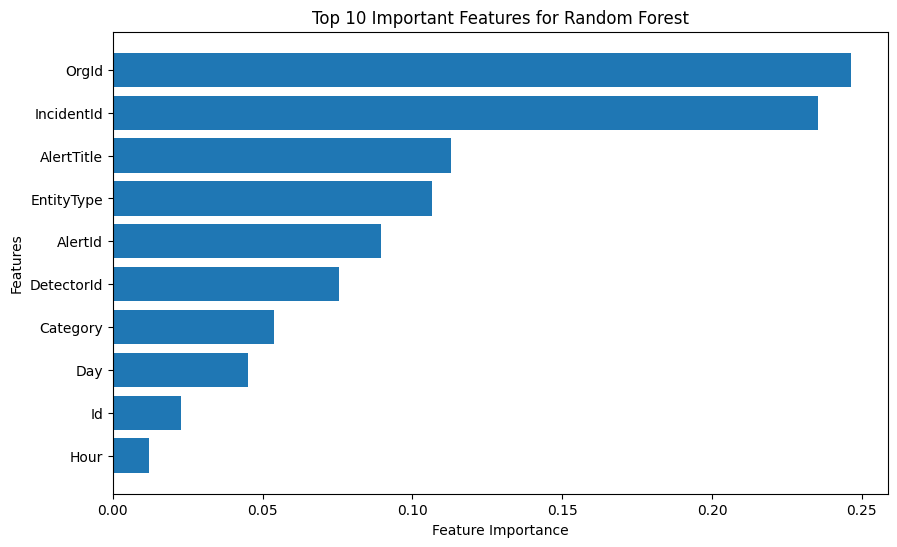

                    Id  OrgId  IncidentId  AlertId  DetectorId  AlertTitle  \
2866782  1202590845787    255       93422   427272           2    0.003565   
5853101   876173332995    106      159915    51799           2    0.003565   
2005728  1056561955902     56      198873   299938           1    0.001783   
1642181   910533067558    107      116598   155577           1    0.001783   
3927615  1194000909383    310      113763   222355           1    0.001783   

         Category  EntityType  Sha256  IpAddress  AccountSid  AccountName  \
2866782         0          14  138268     360606      441377       453297   
5853101         0          14  138268     360606      441377       453297   
2005728         6           9  138268     360606      441377       453297   
1642181         6          14  138268     360606      441377       453297   
3927615         6          14  138268     360606      441377       453297   

         DeviceName  NetworkMessageId       Day      Hour  State_0.0

In [98]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Get feature importances from the best Random Forest model
importances = best_rf.feature_importances_

features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot feature importance for top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Important Features for Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

# Identify misclassified samples
misclassified_idx = (y_val != y_pred)

# Extract the misclassified samples
misclassified_samples = X_val[misclassified_idx].copy()

# Display the first 5 misclassified samples
print(misclassified_samples.head(5))

# Evaluate the model's predictions
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))